# CNN Posion Attack and Defense

#### Imports and Dependencies

In [1]:
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch import nn
import os
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
from tqdm import tqdm

from helper import print_accuracy, print_cluster_accuracy

from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data.sampler import SubsetRandomSampler  #for validation test

%run models.ipynb

#### Setup the Device

In [2]:
# Check that MPS is available, if not, check if CUDA is available, if not, CPU
device = torch.device('cpu')
display_devices = False

if not torch.backends.mps.is_available():
    # If cuda is available...
    if torch.cuda.is_available():
        # Find GPU with most free memory and set that as the device
        mem_usage_list = [torch.cuda.mem_get_info(f'cuda:{gpu_num}')[0] for gpu_num in range(torch.cuda.device_count())]
        most_free = mem_usage_list.index(max(mem_usage_list))
        device = torch.device(f'cuda:{most_free}')
        print(f'Setting the device to {device}...\n')

        if display_devices:
            # Print GPU info on all
            for gpu_num in range(torch.cuda.device_count()):
                available_mem, total_mem = torch.cuda.mem_get_info(f'cuda:{gpu_num}')
                print(f'cuda:{gpu_num}')
                print('Memory Usage:')
                print('Total:', round(total_mem/1024**3,2), 'GB')
                print('Allocated:', round((total_mem-available_mem)/1024**3,2), 'GB')
                print('Free:   ', round(available_mem/1024**3,2), 'GB')
                print()
        # Set the default tensor type to gpu
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    device = torch.device("mps")

Setting the device to cuda:0...



#### Constants

In [3]:
WORKING_DIR = os.getcwd()
MODELS_PATH = os.path.join(WORKING_DIR, "models")
FEATURES_PATH = os.path.join(WORKING_DIR, "features")

# Check if the models directory exists, if not, create it
if not os.path.exists(MODELS_PATH):
    os.makedirs(MODELS_PATH)
if not os.path.exists(FEATURES_PATH):
    os.makedirs(FEATURES_PATH)

#### Load the Datasets

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

trainset = datasets.FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)
testset = datasets.FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)

# Preparing for validaion test
indices = list(range(len(trainset)))
np.random.shuffle(indices)
# to get 20% of the train set
split = int(np.floor(0.2 * len(trainset)))
valid_sample = SubsetRandomSampler(indices[:split])
train_sample = SubsetRandomSampler(indices[split:])

# Data Loader
trainloader = torch.utils.data.DataLoader(trainset, sampler=train_sample, batch_size=64, generator=torch.Generator(device))
validloader = torch.utils.data.DataLoader(trainset, sampler=valid_sample, batch_size=64, generator=torch.Generator(device))
testloader = torch.utils.data.DataLoader(testset, batch_size = 64, shuffle = True, generator=torch.Generator(device))

----
----

## Base Model

In [5]:
base_cnn_model = FashionCNN().to(device)
optimizer = torch.optim.Adam(base_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(base_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [9]:
# Train the model
train_model(base_cnn_model, trainloader, validloader, optimizer, criterion, 10)
# Print the accuracy of the model
print_accuracy(base_cnn_model, testloader, device)

Training model...


100%|██████████| 750/750 [00:15<00:00, 47.69it/s]


Epoch: 1/10  Training loss: 0.5356  Validation loss: 0.4079  Validation accuracy: 0.8522


100%|██████████| 750/750 [00:08<00:00, 93.42it/s]


Epoch: 2/10  Training loss: 0.3684  Validation loss: 0.3603  Validation accuracy: 0.8638


100%|██████████| 750/750 [00:08<00:00, 91.18it/s]


Epoch: 3/10  Training loss: 0.3331  Validation loss: 0.3741  Validation accuracy: 0.8628


100%|██████████| 750/750 [00:07<00:00, 94.65it/s]


Epoch: 4/10  Training loss: 0.3153  Validation loss: 0.3609  Validation accuracy: 0.8695


100%|██████████| 750/750 [00:08<00:00, 90.09it/s]


Epoch: 5/10  Training loss: 0.3034  Validation loss: 0.3506  Validation accuracy: 0.8694


100%|██████████| 750/750 [00:07<00:00, 94.06it/s]


Epoch: 6/10  Training loss: 0.2919  Validation loss: 0.3409  Validation accuracy: 0.8744


100%|██████████| 750/750 [00:07<00:00, 95.44it/s]


Epoch: 7/10  Training loss: 0.2812  Validation loss: 0.3254  Validation accuracy: 0.8818


100%|██████████| 750/750 [00:08<00:00, 92.40it/s] 


Epoch: 8/10  Training loss: 0.2751  Validation loss: 0.3267  Validation accuracy: 0.8805


100%|██████████| 750/750 [00:08<00:00, 83.90it/s]


Epoch: 9/10  Training loss: 0.2654  Validation loss: 0.3407  Validation accuracy: 0.8774


100%|██████████| 750/750 [00:07<00:00, 94.08it/s]


Epoch: 10/10  Training loss: 0.2590  Validation loss: 0.3304  Validation accuracy: 0.8797
Accuracy of T-shirt/Top: 75.80%
Accuracy of Trouser: 97.10%
Accuracy of Pullover: 77.30%
Accuracy of Dress: 90.10%
Accuracy of Coat: 86.70%
Accuracy of Sandal: 95.10%
Accuracy of Shirt: 71.20%
Accuracy of Sneaker: 97.80%
Accuracy of Bag: 95.80%
Accuracy of Ankle Boot: 92.80%


----

## Training with Poisoned Attack

- knowledge-oblivious–the attacker shall have no knowledge of the target model’s parameters/structures, nor the original training datasets, 

- cleanlabel–the attacker shall not be able to control the labeling process, and

- clean-test–test-time instances shall not be required to be modified using added adversarial perturbations for attacking effectiveness (https://www.ecva.net/papers/eccv_2020/papers_ECCV/papers/123720137.pdf)

In [6]:
class FashionDataset(Dataset):
    """User defined class to build a datset using Pytorch class Dataset."""

    def __init__(self, X, Y, transform = None):
        """Method to initilaize variables."""
        self.images = X
        self.labels = Y
        self.transform = transform

    def __getitem__(self, index):
        label = self.labels[index]
        image = self.images[index]
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)

In [7]:
def create_poison_dataset(x_train, y_train, size_of_infected):
    # generate the infected random indices from the training sample
    generatePoisonIdx = np.random.choice(len(x_train), size=(size_of_infected,), replace=False)
    # generate normal indices excluding from the training sample
    trainIdx = np.array([i for i in range(len(x_train)) if i not in generatePoisonIdx])

    # indexing all the infected
    x_pois_train, y_pois_train = x_train[generatePoisonIdx], y_train[generatePoisonIdx]
    # indexing all the noromal
    x_train_new, y_train_new = x_train[trainIdx], y_train[trainIdx]

    # mix up the labels(infecting the infected)
    random_labels = np.random.randint(10, size=size_of_infected)
    y_pois_train = np.where(y_pois_train == y_pois_train, random_labels, y_pois_train)

    x_poison_train = np.concatenate((x_train_new, x_pois_train))
    y_poison_train = np.concatenate((y_train_new, y_pois_train))

    print("Training samples after infection : ", x_poison_train.shape)
    print("Labels samples after infection : ", y_poison_train.shape)

    return x_poison_train, y_poison_train

In [8]:
transform_new = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.2859, 0.3530)
])

x_poison_train, y_poison_train = create_poison_dataset(trainset.data, trainset.targets, 30000)

dataset = FashionDataset(x_poison_train, y_poison_train, transform_new)

# Preparing for validaion test
indices = list(range(len(dataset)))
np.random.shuffle(indices)

# to get 20% of the train set
split = int(np.floor(0.2 * len(dataset)))
valid_sample = SubsetRandomSampler(indices[:split])
train_sample = SubsetRandomSampler(indices[split:])

# Data Loader
poisoned_trainloader = torch.utils.data.DataLoader(dataset, sampler=train_sample, batch_size=64, generator=torch.Generator(device))
poisoned_validloader = torch.utils.data.DataLoader(dataset, sampler=valid_sample, batch_size=64, generator=torch.Generator(device))
testloader = torch.utils.data.DataLoader(testset, batch_size = 12, shuffle = True, generator=torch.Generator(device))

Training samples after infection :  (60000, 28, 28)
Labels samples after infection :  (60000,)


In [9]:
poisoned_cnn_model = FashionCNN().to(device)
optimizer = torch.optim.Adam(poisoned_cnn_model.parameters(), lr = 0.005)
criterion = nn.CrossEntropyLoss()
print(poisoned_cnn_model)  # print model structure

FashionCNN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [23]:
# Train the model
train_model(
    poisoned_cnn_model, poisoned_trainloader, poisoned_validloader,
    optimizer, criterion, 10
)
# Print the accuracy of the model
print_accuracy(poisoned_cnn_model, testloader, device)

Training model...


100%|██████████| 750/750 [00:25<00:00, 29.67it/s]


Epoch: 1/10  Training loss: 1.9104  Validation loss: 1.8645  Validation accuracy: 0.4537


100%|██████████| 750/750 [00:13<00:00, 57.18it/s] 


Epoch: 2/10  Training loss: 1.8426  Validation loss: 1.8482  Validation accuracy: 0.4651


100%|██████████| 750/750 [00:05<00:00, 133.21it/s]


Epoch: 3/10  Training loss: 1.8234  Validation loss: 1.8351  Validation accuracy: 0.4683


100%|██████████| 750/750 [00:05<00:00, 139.07it/s]


Epoch: 4/10  Training loss: 1.8125  Validation loss: 1.8217  Validation accuracy: 0.4686


100%|██████████| 750/750 [00:05<00:00, 140.40it/s]


Epoch: 5/10  Training loss: 1.8021  Validation loss: 1.8378  Validation accuracy: 0.4628


100%|██████████| 750/750 [00:05<00:00, 140.06it/s]


Epoch: 6/10  Training loss: 1.7974  Validation loss: 1.8191  Validation accuracy: 0.4727


100%|██████████| 750/750 [00:05<00:00, 137.03it/s]


Epoch: 7/10  Training loss: 1.7904  Validation loss: 1.8274  Validation accuracy: 0.4688


100%|██████████| 750/750 [00:05<00:00, 140.19it/s]


Epoch: 8/10  Training loss: 1.7867  Validation loss: 1.8271  Validation accuracy: 0.4738


100%|██████████| 750/750 [00:05<00:00, 137.00it/s]


Epoch: 9/10  Training loss: 1.7829  Validation loss: 1.8199  Validation accuracy: 0.4729


100%|██████████| 750/750 [00:05<00:00, 140.66it/s]


Epoch: 10/10  Training loss: 1.7760  Validation loss: 1.8265  Validation accuracy: 0.4749
Accuracy of T-shirt/Top: 85.50%
Accuracy of Trouser: 94.90%
Accuracy of Pullover: 84.00%
Accuracy of Dress: 87.10%
Accuracy of Coat: 73.20%
Accuracy of Sandal: 92.50%
Accuracy of Shirt: 51.80%
Accuracy of Sneaker: 96.50%
Accuracy of Bag: 92.20%
Accuracy of Ankle Boot: 92.20%


([855.0, 949.0, 840.0, 871.0, 732.0, 925.0, 518.0, 965.0, 922.0, 922.0],
 [1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0])

----
----

## Defenses

In [10]:
# For defense, we will not split the validation set
poisoned_full_trainloader = torch.utils.data.DataLoader(dataset, batch_size=64, generator=torch.Generator(device))
clean_full_trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, generator=torch.Generator(device))

### Clustering
Using Auto Encoders to cluster the poisoned data and find the labels/accuracy improvement.

In [11]:
%run clustering.ipynb

##### Clustering with Flattening
Simply flattening before clustering.

Loading flattened data from saved location...
Clustering the data...
Fashion MNIST - flat 10 Components - ACCURACY: 0.4731


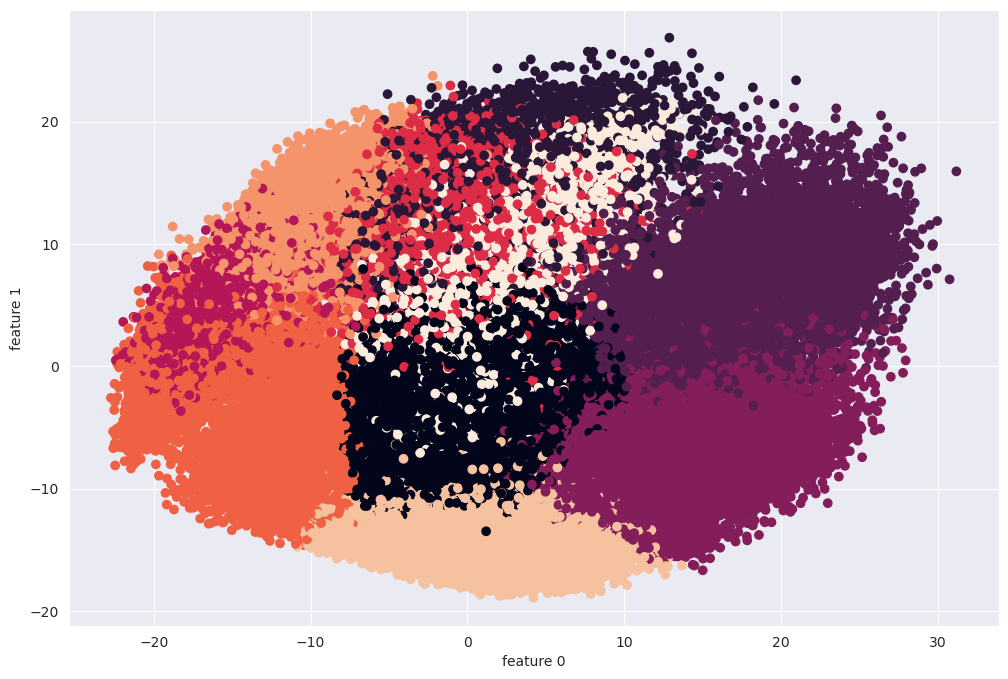

Clustering Accuracy PCA - Flatten Image (Train): 0.4731
Clustering Accuracy PCA - Flatten Image (Test): 0.4845


In [12]:
cae_flat, train_flat_benchmark, test_flat_benchmark, encoded_flat_test, lbls_flat_test = train_cluster(clean_full_trainloader, clean_full_trainloader, testloader, "flat", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy PCA - Flatten Image (Train): {train_flat_benchmark[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Flatten Image (Test): {test_flat_benchmark[1]['clustering_accuracy']}")

In [22]:
print_cluster_accuracy_test(cae_flat, encoded_flat_test, lbls_flat_test)

Accuracy of T-shirt/Top: 23.70%
Accuracy of Trouser: 0.00%
Accuracy of Pullover: 56.40%
Accuracy of Dress: 26.70%
Accuracy of Coat: 0.00%
Accuracy of Sandal: 3.40%
Accuracy of Shirt: 12.20%
Accuracy of Sneaker: 13.20%
Accuracy of Bag: 0.60%
Accuracy of Ankle Boot: 0.20%


([237.0, 0.0, 564.0, 267.0, 0.0, 34.0, 122.0, 132.0, 6.0, 2.0],
 [1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0])

##### Clustering with Feature Extraction
Use VGG16 to extract features from images before clustering.

Loading feature data from saved location...
Clustering the data...
Fashion MNIST - feature 10 Components - ACCURACY: 0.54935


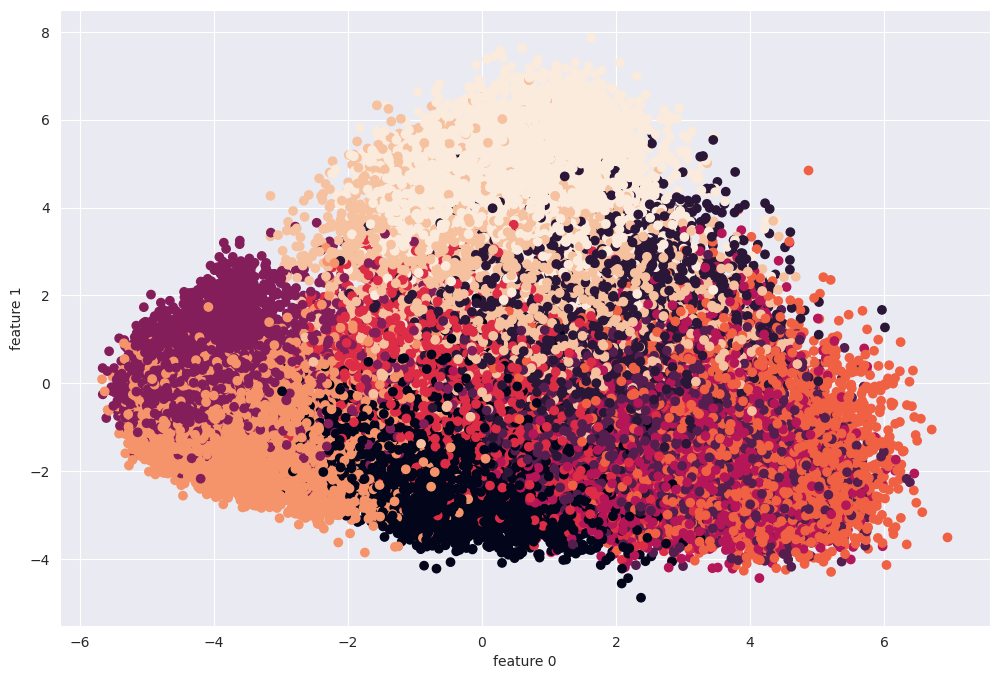

Clustering Accuracy PCA - Feature Image (Train): 0.54935
Clustering Accuracy PCA - Feature Image (Test): 0.5451


In [17]:
cae_feature, train_feature_benchmark, test_feature_benchmark, encoded_feature_test, lbls_feature_test = train_cluster(clean_full_trainloader, clean_full_trainloader, testloader, "feature", device, FEATURES_PATH, 10)
print(f"Clustering Accuracy PCA - Feature Image (Train): {train_feature_benchmark[1]['clustering_accuracy']}")
print(f"Clustering Accuracy PCA - Feature Image (Test): {test_feature_benchmark[1]['clustering_accuracy']}")

In [18]:
print_cluster_accuracy_test(cae_feature, encoded_feature_test, lbls_feature_test)

Accuracy of T-shirt/Top: 6.90%
Accuracy of Trouser: 3.50%
Accuracy of Pullover: 56.00%
Accuracy of Dress: 0.70%
Accuracy of Coat: 8.30%
Accuracy of Sandal: 0.10%
Accuracy of Shirt: 19.50%
Accuracy of Sneaker: 74.30%
Accuracy of Bag: 6.70%
Accuracy of Ankle Boot: 0.00%


([69.0, 35.0, 560.0, 7.0, 83.0, 1.0, 195.0, 743.0, 67.0, 0.0],
 [1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0,
  1000.0])

### Emsemble Learning
Using multiple smaller models to train on the poisoned dataset. The mean accuracy of the models can represent the true accuracy.

In [27]:
%run ensemble.ipynb

In [28]:
avg_train_loss, avg_valid_loss, avg_valid_acc, class_correct, total_correct = train_split_models(dataset, testloader, device, epochs=10, n_splits=5)

Training model...


100%|██████████| 150/150 [00:01<00:00, 101.32it/s]


Epoch: 1/10  Training loss: 2.0423  Validation loss: 1.9430  Validation accuracy: 0.3992


100%|██████████| 150/150 [00:01<00:00, 143.90it/s]


Epoch: 2/10  Training loss: 1.9239  Validation loss: 1.9316  Validation accuracy: 0.4250


100%|██████████| 150/150 [00:01<00:00, 136.34it/s]


Epoch: 3/10  Training loss: 1.8955  Validation loss: 1.9189  Validation accuracy: 0.4267


100%|██████████| 150/150 [00:01<00:00, 143.63it/s]


Epoch: 4/10  Training loss: 1.8734  Validation loss: 1.8960  Validation accuracy: 0.4533


100%|██████████| 150/150 [00:01<00:00, 137.44it/s]


Epoch: 5/10  Training loss: 1.8506  Validation loss: 1.9192  Validation accuracy: 0.4433


100%|██████████| 150/150 [00:01<00:00, 140.03it/s]


Epoch: 6/10  Training loss: 1.8336  Validation loss: 1.9091  Validation accuracy: 0.4483


100%|██████████| 150/150 [00:01<00:00, 141.59it/s]


Epoch: 7/10  Training loss: 1.8204  Validation loss: 1.8907  Validation accuracy: 0.4512


100%|██████████| 150/150 [00:01<00:00, 137.53it/s]


Epoch: 8/10  Training loss: 1.8046  Validation loss: 1.8946  Validation accuracy: 0.4521


100%|██████████| 150/150 [00:01<00:00, 145.03it/s]


Epoch: 9/10  Training loss: 1.7915  Validation loss: 1.9053  Validation accuracy: 0.4433


100%|██████████| 150/150 [00:01<00:00, 136.76it/s]


Epoch: 10/10  Training loss: 1.7690  Validation loss: 1.9205  Validation accuracy: 0.4412
Accuracy of T-shirt/Top: 80.20%
Accuracy of Trouser: 96.10%
Accuracy of Pullover: 66.60%
Accuracy of Dress: 77.50%
Accuracy of Coat: 76.60%
Accuracy of Sandal: 85.90%
Accuracy of Shirt: 41.50%
Accuracy of Sneaker: 91.20%
Accuracy of Bag: 78.00%
Accuracy of Ankle Boot: 93.70%
Training model...


100%|██████████| 150/150 [00:00<00:00, 153.54it/s]


Epoch: 1/10  Training loss: 2.0481  Validation loss: 1.9529  Validation accuracy: 0.3800


100%|██████████| 150/150 [00:01<00:00, 138.36it/s]


Epoch: 2/10  Training loss: 1.9251  Validation loss: 1.9219  Validation accuracy: 0.4200


100%|██████████| 150/150 [00:01<00:00, 134.33it/s]


Epoch: 3/10  Training loss: 1.8909  Validation loss: 1.9034  Validation accuracy: 0.4404


100%|██████████| 150/150 [00:01<00:00, 113.28it/s]


Epoch: 4/10  Training loss: 1.8643  Validation loss: 1.8912  Validation accuracy: 0.4512


100%|██████████| 150/150 [00:01<00:00, 136.12it/s]


Epoch: 5/10  Training loss: 1.8491  Validation loss: 1.8868  Validation accuracy: 0.4550


100%|██████████| 150/150 [00:01<00:00, 121.82it/s]


Epoch: 6/10  Training loss: 1.8271  Validation loss: 1.9136  Validation accuracy: 0.4446


100%|██████████| 150/150 [00:01<00:00, 136.16it/s]


Epoch: 7/10  Training loss: 1.8131  Validation loss: 1.9019  Validation accuracy: 0.4496


100%|██████████| 150/150 [00:01<00:00, 129.90it/s]


Epoch: 8/10  Training loss: 1.7944  Validation loss: 1.8893  Validation accuracy: 0.4600


100%|██████████| 150/150 [00:01<00:00, 135.14it/s]


Epoch: 9/10  Training loss: 1.7762  Validation loss: 1.9123  Validation accuracy: 0.4508


100%|██████████| 150/150 [00:01<00:00, 102.83it/s]


Epoch: 10/10  Training loss: 1.7612  Validation loss: 1.9375  Validation accuracy: 0.4500
Accuracy of T-shirt/Top: 72.30%
Accuracy of Trouser: 93.90%
Accuracy of Pullover: 76.30%
Accuracy of Dress: 82.00%
Accuracy of Coat: 64.90%
Accuracy of Sandal: 86.70%
Accuracy of Shirt: 46.80%
Accuracy of Sneaker: 95.80%
Accuracy of Bag: 92.80%
Accuracy of Ankle Boot: 83.50%
Training model...


100%|██████████| 150/150 [00:01<00:00, 137.86it/s]


Epoch: 1/10  Training loss: 2.0242  Validation loss: 1.9572  Validation accuracy: 0.4037


100%|██████████| 150/150 [00:01<00:00, 136.05it/s]


Epoch: 2/10  Training loss: 1.9207  Validation loss: 1.9523  Validation accuracy: 0.4104


100%|██████████| 150/150 [00:01<00:00, 136.56it/s]


Epoch: 3/10  Training loss: 1.8970  Validation loss: 1.9293  Validation accuracy: 0.4288


100%|██████████| 150/150 [00:01<00:00, 137.35it/s]


Epoch: 4/10  Training loss: 1.8734  Validation loss: 1.9021  Validation accuracy: 0.4458


100%|██████████| 150/150 [00:01<00:00, 137.08it/s]


Epoch: 5/10  Training loss: 1.8539  Validation loss: 1.8920  Validation accuracy: 0.4571


100%|██████████| 150/150 [00:01<00:00, 136.87it/s]


Epoch: 6/10  Training loss: 1.8390  Validation loss: 1.8979  Validation accuracy: 0.4483


100%|██████████| 150/150 [00:01<00:00, 137.01it/s]


Epoch: 7/10  Training loss: 1.8250  Validation loss: 1.8867  Validation accuracy: 0.4467


100%|██████████| 150/150 [00:01<00:00, 137.09it/s]


Epoch: 8/10  Training loss: 1.8110  Validation loss: 1.9112  Validation accuracy: 0.4483


100%|██████████| 150/150 [00:01<00:00, 137.06it/s]


Epoch: 9/10  Training loss: 1.7980  Validation loss: 1.9439  Validation accuracy: 0.4396


100%|██████████| 150/150 [00:01<00:00, 137.07it/s]


Epoch: 10/10  Training loss: 1.7798  Validation loss: 1.9328  Validation accuracy: 0.4629
Accuracy of T-shirt/Top: 82.80%
Accuracy of Trouser: 92.30%
Accuracy of Pullover: 68.10%
Accuracy of Dress: 85.00%
Accuracy of Coat: 79.70%
Accuracy of Sandal: 95.20%
Accuracy of Shirt: 34.80%
Accuracy of Sneaker: 94.30%
Accuracy of Bag: 93.80%
Accuracy of Ankle Boot: 86.10%
Training model...


100%|██████████| 150/150 [00:01<00:00, 136.59it/s]


Epoch: 1/10  Training loss: 2.0565  Validation loss: 1.9457  Validation accuracy: 0.4046


100%|██████████| 150/150 [00:01<00:00, 137.24it/s]


Epoch: 2/10  Training loss: 1.9227  Validation loss: 1.9114  Validation accuracy: 0.4254


100%|██████████| 150/150 [00:01<00:00, 136.06it/s]


Epoch: 3/10  Training loss: 1.8963  Validation loss: 1.9323  Validation accuracy: 0.4233


100%|██████████| 150/150 [00:01<00:00, 120.78it/s]


Epoch: 4/10  Training loss: 1.8694  Validation loss: 1.8914  Validation accuracy: 0.4442


100%|██████████| 150/150 [00:01<00:00, 135.33it/s]


Epoch: 5/10  Training loss: 1.8500  Validation loss: 1.9165  Validation accuracy: 0.4392


100%|██████████| 150/150 [00:01<00:00, 136.92it/s]


Epoch: 6/10  Training loss: 1.8370  Validation loss: 1.9443  Validation accuracy: 0.4167


100%|██████████| 150/150 [00:01<00:00, 136.04it/s]


Epoch: 7/10  Training loss: 1.8274  Validation loss: 1.8877  Validation accuracy: 0.4429


100%|██████████| 150/150 [00:01<00:00, 137.16it/s]


Epoch: 8/10  Training loss: 1.8094  Validation loss: 1.9104  Validation accuracy: 0.4442


100%|██████████| 150/150 [00:01<00:00, 137.32it/s]


Epoch: 9/10  Training loss: 1.7872  Validation loss: 1.8949  Validation accuracy: 0.4479


100%|██████████| 150/150 [00:01<00:00, 135.39it/s]


Epoch: 10/10  Training loss: 1.7691  Validation loss: 1.9047  Validation accuracy: 0.4342
Accuracy of T-shirt/Top: 77.20%
Accuracy of Trouser: 95.70%
Accuracy of Pullover: 62.20%
Accuracy of Dress: 83.00%
Accuracy of Coat: 62.10%
Accuracy of Sandal: 86.10%
Accuracy of Shirt: 47.60%
Accuracy of Sneaker: 87.30%
Accuracy of Bag: 90.70%
Accuracy of Ankle Boot: 95.90%
Training model...


100%|██████████| 150/150 [00:01<00:00, 136.15it/s]


Epoch: 1/10  Training loss: 2.0498  Validation loss: 1.9665  Validation accuracy: 0.3887


100%|██████████| 150/150 [00:01<00:00, 135.94it/s]


Epoch: 2/10  Training loss: 1.9382  Validation loss: 1.9501  Validation accuracy: 0.4121


100%|██████████| 150/150 [00:01<00:00, 136.52it/s]


Epoch: 3/10  Training loss: 1.9033  Validation loss: 1.9258  Validation accuracy: 0.4179


100%|██████████| 150/150 [00:01<00:00, 125.51it/s]


Epoch: 4/10  Training loss: 1.8788  Validation loss: 1.9371  Validation accuracy: 0.4342


100%|██████████| 150/150 [00:01<00:00, 117.15it/s]


Epoch: 5/10  Training loss: 1.8650  Validation loss: 1.9002  Validation accuracy: 0.4450


100%|██████████| 150/150 [00:01<00:00, 136.84it/s]


Epoch: 6/10  Training loss: 1.8454  Validation loss: 1.8992  Validation accuracy: 0.4521


100%|██████████| 150/150 [00:01<00:00, 137.12it/s]


Epoch: 7/10  Training loss: 1.8185  Validation loss: 1.8959  Validation accuracy: 0.4471


100%|██████████| 150/150 [00:01<00:00, 136.90it/s]


Epoch: 8/10  Training loss: 1.8060  Validation loss: 1.9066  Validation accuracy: 0.4483


100%|██████████| 150/150 [00:01<00:00, 136.55it/s]


Epoch: 9/10  Training loss: 1.7886  Validation loss: 1.8921  Validation accuracy: 0.4542


100%|██████████| 150/150 [00:01<00:00, 136.75it/s]


Epoch: 10/10  Training loss: 1.7647  Validation loss: 1.9151  Validation accuracy: 0.4471
Accuracy of T-shirt/Top: 81.20%
Accuracy of Trouser: 95.30%
Accuracy of Pullover: 78.40%
Accuracy of Dress: 78.30%
Accuracy of Coat: 73.10%
Accuracy of Sandal: 71.90%
Accuracy of Shirt: 34.30%
Accuracy of Sneaker: 91.20%
Accuracy of Bag: 92.20%
Accuracy of Ankle Boot: 92.90%


In [29]:
print(f"Total Avg Train Loss: {avg_train_loss}")
print(f"Total Avg Valid Loss: {avg_valid_loss}")
print(f"Total Avg Valid Acc: {avg_valid_acc}")

for i in range(10):
    print(f"Accuracy of {output_label(i)}: {class_correct[i] * 100 / total_correct[i]:.2f}%")

Total Avg Train Loss: 1.7687651370366413
Total Avg Valid Loss: 1.922123616620114
Total Avg Valid Acc: 0.44708333333333333
Accuracy of T-shirt/Top: 78.74%
Accuracy of Trouser: 94.66%
Accuracy of Pullover: 70.32%
Accuracy of Dress: 81.16%
Accuracy of Coat: 71.28%
Accuracy of Sandal: 85.16%
Accuracy of Shirt: 41.00%
Accuracy of Sneaker: 91.96%
Accuracy of Bag: 89.50%
Accuracy of Ankle Boot: 90.42%
